##### Eval Network
This file evaluates a trained network


In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

import matplotlib
# %matplotlib notebook
import matplotlib.pyplot as plt

import glob
import os
import _pickle as pickle

# import externally defined network structures and data loaders
import auxiliary as aux

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# select a GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(os.getpid())

cuda:0
919


### Load model from disk

In [38]:
conf_name = '9_test_multiple_datasets'
try:
    c = aux.conf[conf_name]
    print('config "%s" selected. available checkpoints: ' % conf_name)
    print('\n'.join(sorted(glob.glob('./Networks/%s/%s.ckp*' % (conf_name, conf_name)), key=os.path.getmtime)))
except:
    print('config %s not available! (available configs: %s)' % (conf_name, aux.conf.keys()))

config "9_test_multiple_datasets" selected. available checkpoints: 
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#76
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#101
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#126
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#151
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#176
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#201
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#226
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#251
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#276
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#301
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#326
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#351
./Networks/9_test_multiple_datasets/9_test_multiple_datasets.ckp#376


In [39]:
# specify checkpoint to load
# ckp_fname = 'linear_layer_u_hat.ckp#70'
ckp_fname = sorted(glob.glob('./Networks/%s/%s.ckp*' % (conf_name, conf_name)), key=os.path.getmtime)[-1].split('/')[-1] # take most recent one

# define empty network, optimizer and loss function
net = c['network']().to(device)
try:
    state = torch.load('./Networks/%s/%s' % (conf_name, ckp_fname))
    net.load_state_dict(state['network_dict'])
    net.eval()
    print('checkpoint "%s" loaded' % ckp_fname)
except Exception as e:
    print('loading of checkpoint %s failed! (%s)' % (ckp_fname, e))

checkpoint "9_test_multiple_datasets.ckp#376" loaded


[]


<IPython.core.display.Javascript object>


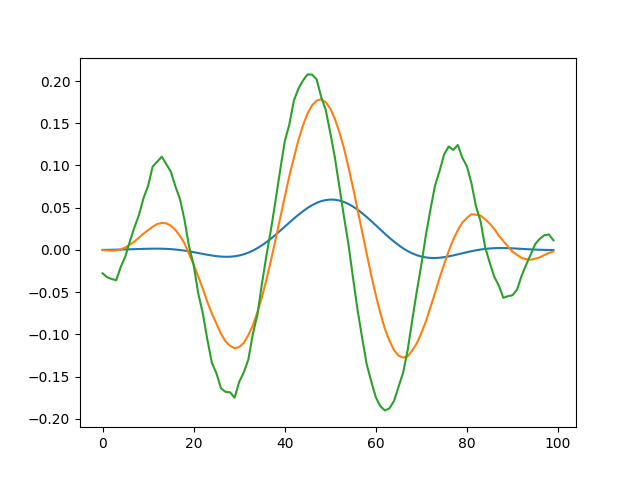

In [47]:
weights = net.lin_1.weight.cpu().detach().numpy()
print((weights[0,500:600:3])*100000)
plt.figure()
plt.plot(weights[0][::3])
plt.plot(weights[0][1::3]*50)
plt.plot(weights[0][2::3]*500)
plt.show()


### Select and load dataset, create data loader

In [48]:
# specify eval data set
eval_fname = 'eval_bandlimited_rand_noise_10k_32_3_2_2.pkl'
# eval_fname = c['dataset_test']
print("loading dataset from file ..")
ds_load_eval = pickle.load(open('./Datasets/' + eval_fname, 'rb', -1))

params_eval = {'batch_size': 10000, 'shuffle': False, 'num_workers': 8}
ds_eval = aux.DatasetStream([ds_load_eval['y']], [ds_load_eval['x']], c)
data_loader_eval = data.DataLoader(ds_eval, **params_eval) 
print("loading done. length of data set: %i samples" % ds_eval.__len__())

loading dataset from file ..
loading done. length of data set: 9901 samples


### Eval network

<IPython.core.display.Javascript object>


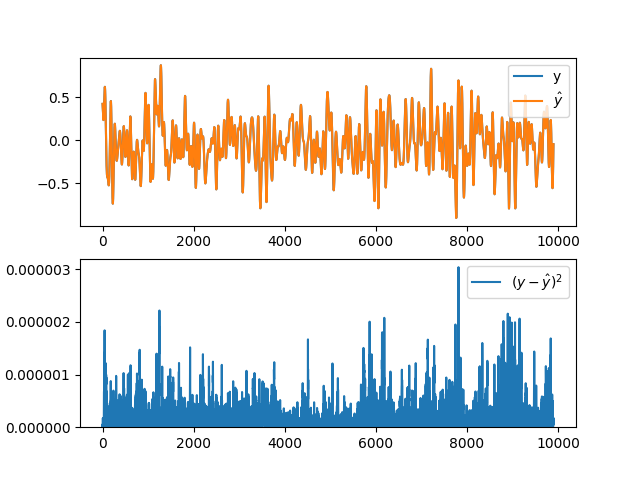

MSE: 0.000000
SNR: -67.232596
Expected SNR: 154.930946
Effective Number of bits: 25.4436787344452


In [50]:
n_batch = params_eval['batch_size']
y_hat = np.zeros(ds_eval.__len__())
y = np.zeros(ds_eval.__len__())

for i, (batch_data, batch_labels) in enumerate(data_loader_eval): 
        batch_data = Variable(batch_data).float().cuda(async=True) 
        batch_labels = Variable(batch_labels).float().cuda(async=True)
        n_batch_now = batch_labels.shape[0]
        
        y_hat[i * n_batch : i * n_batch + n_batch_now] = net(batch_data).cpu().detach().numpy().flatten()
        y[i * n_batch : i * n_batch + n_batch_now] = batch_labels.cpu()


squared_error = (y_hat - y)**2

plt.figure(2)
ax_1 = plt.subplot(211)
plt.plot(y, label='y')
plt.plot(y_hat, label='$\hat y$')
plt.legend()

ax_2 = plt.subplot(212, sharex=ax_1)
plt.plot(squared_error, label='($y-\hat y)^2$')
plt.ylim(ymin=1e-11)
plt.legend()
plt.show()

# print statistics
mse = ((y - y_hat) ** 2).mean()
sig_energy = (y**2).mean()
snr = 10 * np.log10(mse)
systemOrder = 6

DR = 1 * 6.02 + 1.76 + 10 * np.log10(2 * systemOrder + 1) - 20 * systemOrder * np.log10(np.pi) + 10 * (2 * systemOrder + 1) * np.log10(c['OSR'])
ENOB = (DR - 1.76) / 6.02
print('MSE: %f\nSNR: %f' % (mse,snr))
print('Expected SNR: %f\nEffective Number of bits: %s' % (DR, ENOB))
